In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
# loading data
customers = pd.read_csv('QVI_purchase_behaviour.csv')
transactions = pd.read_excel('QVI_transaction_data.xlsx')

In [3]:
customers.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [4]:
transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


# Data cleaning

## Customer Table

In [5]:
customers.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [7]:
# no null entries in the columns

In [8]:
customers.tail()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget
72636,2373711,YOUNG SINGLES/COUPLES,Mainstream


In [9]:
customers.loc[:,'LYLTY_CARD_NBR'].nunique()

72637

In [10]:
# there are all unique entries
# this indicates unique entries in the table
# the LYLTY_CARD_NBR column is clean

In [11]:
customers.loc[:,'LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [12]:
# the unique entries in LIFESTAGE all appear clean

In [13]:
customers.loc[:,'PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

In [14]:
# the unique entries in PREMIUM_CUSTOMER all appear clean

In [15]:
# examining PREMIUM_CUSTOMER and LYLTY_CARD_NBR together
pd.crosstab(customers.LIFESTAGE,customers.PREMIUM_CUSTOMER)

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,1504,3340,2431
NEW FAMILIES,1112,849,588
OLDER FAMILIES,4675,2831,2274
OLDER SINGLES/COUPLES,4929,4930,4750
RETIREES,4454,6479,3872
YOUNG FAMILIES,4017,2728,2433
YOUNG SINGLES/COUPLES,3779,8088,2574


## Transaction Table

In [16]:
transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [17]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [18]:
# no null entries

In [19]:
# the analysis project is limited to chips
# lets verify this in the dataset

In [20]:
# extract all the words in the product name column
product_words= transactions['PROD_NAME'].str.split(expand=True).stack().reset_index(drop=True)
product_words

0              Natural
1                 Chip
2               Compny
3          SeaSalt175g
4                  CCs
              ...     
1359079       Tostitos
1359080         Splash
1359081             Of
1359082           Lime
1359083           175g
Length: 1359084, dtype: object

In [21]:
# lets focus on words relevant to identifying if the product is a bag of chips
# remove words containing special characters and numbers
product_words = product_words[~product_words.str.contains(r'\d')]
product_words = product_words[product_words.str.match(r'^[a-zA-Z]+$')]

In [22]:
# further analysis
product_words.nunique()

168

In [23]:
# since only a few unique lets examine number them
product_words.unique()

array(['Natural', 'Chip', 'Compny', 'CCs', 'Nacho', 'Cheese', 'Smiths',
       'Crinkle', 'Cut', 'Chips', 'Chicken', 'Thinly', 'Kettle',
       'Tortilla', 'Chili', 'Old', 'El', 'Paso', 'Salsa', 'Dip', 'Tomato',
       'Mild', 'Salt', 'Vinegar', 'Grain', 'Waves', 'Sweet', 'Chilli',
       'Doritos', 'Corn', 'Mexican', 'Jalapeno', 'Sour', 'Sensations',
       'Siracha', 'Lime', 'Twisties', 'WW', 'Thins', 'Tangy', 'Original',
       'Burger', 'Rings', 'NCC', 'Cream', 'Garden', 'Chives', 'Southern',
       'Cheezels', 'Box', 'Infzns', 'Crn', 'Crnchers', 'Gcamole', 'Sea',
       'And', 'Red', 'Rock', 'Deli', 'Thai', 'Pringles', 'Sthrn',
       'FriedChicken', 'BBQ', 'SR', 'Mzzrlla', 'Originl', 'saltd', 'Sp',
       'Truffle', 'Swt', 'Mexicana', 'French', 'OnionDip', 'ChipCo',
       'Hony', 'Soy', 'Dorito', 'Chp', 'Supreme', 'Roast', 'Mozzarella',
       'Basil', 'Pesto', 'Infuzions', 'SweetChili', 'PotatoMix',
       'Camembert', 'Fig', 'Smith', 'Mac', 'N', 'Honey',
       'Seasonedchicke

In [24]:
# from this list, salsa products might be in the list of products

transactions['PROD_NAME'][transactions['PROD_NAME'].str.lower().str.contains('salsa')]

5         Old El Paso Salsa   Dip Tomato Mild 300g
25        Old El Paso Salsa   Dip Tomato Mild 300g
32        Red Rock Deli SR    Salsa & Mzzrlla 150g
44           Smiths Crinkle Cut  Tomato Salsa 150g
63                 Doritos Salsa       Medium 300g
                            ...                   
264675     Old El Paso Salsa   Dip Tomato Med 300g
264678              Woolworths Mild     Salsa 300g
264719       Smiths Crinkle Cut  Tomato Salsa 150g
264734                    Doritos Salsa Mild  300g
264780    Red Rock Deli SR    Salsa & Mzzrlla 150g
Name: PROD_NAME, Length: 18094, dtype: object

In [25]:
# eliminate salsa products
transactions=transactions[~transactions['PROD_NAME'].str.lower().str.contains('salsa')]
transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [26]:
# fixing date datatype
transactions['DATE']= pd.to_datetime(transactions['DATE'], unit='D', origin='1899-12-30')

In [27]:
transactions['DATE']

0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
264831   2019-03-09
264832   2018-08-13
264833   2018-11-06
264834   2018-12-27
264835   2018-09-22
Name: DATE, Length: 246742, dtype: datetime64[ns]

In [28]:
# the data is supposed to cover a year of transactions lets ensure this
transactions['DATE'].nunique()

364

In [29]:
# this needs to be investigated further

In [30]:
# create the desired date range
transactions['DATE'].min()

# Start date
start_date = transactions['DATE'].min()

# Generate the range of dates
date_range = np.arange(start_date, start_date + np.timedelta64(365, 'D'), dtype='datetime64[D]')

date_range

array(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
       '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
       '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
       '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
       '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
       '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
       '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
       '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
       '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
       '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
       '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
       '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
       '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
       '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
       '2018-08-26', '2018-08-27', '2018-08-28', '2018-08-29',
       '2018-08-30', '2018-08-31', '2018-09-01', '2018-

In [31]:

date_range[~np.isin(date_range, transactions['DATE'].unique())]

array(['2018-12-25'], dtype='datetime64[D]')

In [32]:
# this is on christmas day. This is as a result of shops being closed.

In [33]:
# investigating store number
transactions.loc[:,'STORE_NBR'].value_counts()

226    1918
88     1786
165    1741
237    1714
93     1699
       ... 
85        2
252       2
206       2
92        1
76        1
Name: STORE_NBR, Length: 271, dtype: int64

In [34]:
# lotalty card number
# ensuring all lotalty card number entries in transaction table are in customer table
transactions.loc[:,'LYLTY_CARD_NBR'].isin(customers.iloc[:,0]).sum()

246742

In [35]:
# number of unique customers
transactions.loc[:,'LYLTY_CARD_NBR'].nunique()

71288

In [36]:
# examing transaction ID
# number of unique transactions
transactions.loc[:,'TXN_ID'].nunique()

245257

In [37]:
transactions.loc[:,'TXN_ID'].max()

2415841

In [38]:
# examining product number
transactions.loc[:,'PROD_NBR'].nunique()

105

In [39]:
# examining numeric columns

In [40]:
transactions.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [41]:
# cleaning product name
transactions.loc[:,'PROD_NAME']

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 246742, dtype: object

In [42]:
# removing extra spaces
transactions.loc[:,'PROD_NAME']=transactions.loc[:,'PROD_NAME'].str.lower().str.strip().str.replace(r'\s+', ' ')

C:\Users\adenu\AppData\Local\Temp\ipykernel_7800\3694262557.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  transactions.loc[:,'PROD_NAME']=transactions.loc[:,'PROD_NAME'].str.lower().str.strip().str.replace(r'\s+', ' ')


In [43]:
# extracting package size
transactions['SIZE'] = transactions.loc[:,'PROD_NAME'].str.extract(r'(\d+)')
transactions['SIZE']

0         175
1         175
2         170
3         175
4         150
         ... 
264831    175
264832    175
264833    170
264834    150
264835    175
Name: SIZE, Length: 246742, dtype: object

In [44]:
# extracting brand names
# assuming the brand name is contained in the first word of an entry
transactions['BRAND_NAME']=transactions.loc[:,'PROD_NAME'].str.split().str[0]
transactions['BRAND_NAME']

0          natural
1              ccs
2           smiths
3           smiths
4           kettle
            ...   
264831      kettle
264832    tostitos
264833     doritos
264834     doritos
264835    tostitos
Name: BRAND_NAME, Length: 246742, dtype: object

In [45]:
transactions['BRAND_NAME'].unique()

array(['natural', 'ccs', 'smiths', 'kettle', 'grain', 'doritos',
       'twisties', 'ww', 'thins', 'burger', 'ncc', 'cheezels', 'infzns',
       'red', 'pringles', 'dorito', 'infuzions', 'smith', 'grnwves',
       'tyrrells', 'cobs', 'french', 'rrd', 'tostitos', 'cheetos',
       'woolworths', 'snbts', 'sunbites'], dtype=object)

In [46]:
# some brand names seem like abbreviations of others and some other inconsistencies need to be corrected

In [47]:
brand_replacements = {
    "rrd": "red",
    "snbts": "sunbites",
    "infzns": "infuzions",
    "ww": "woolworths",
    "smith": "smiths",
    "ncc": "natural",
    "dorito": "doritos",
    "grain": "grnwves"
}


transactions['BRAND_NAME'] = transactions['BRAND_NAME'].replace(brand_replacements)


In [48]:
transactions['BRAND_NAME'].unique()

array(['natural', 'ccs', 'smiths', 'kettle', 'grnwves', 'doritos',
       'twisties', 'woolworths', 'thins', 'burger', 'cheezels',
       'infuzions', 'red', 'pringles', 'tyrrells', 'cobs', 'french',
       'tostitos', 'cheetos', 'sunbites'], dtype=object)

In [49]:
transactions[['BRAND_NAME', 'SIZE']]

,BRAND_NAME,SIZE
0,natural,175
1,ccs,175
2,smiths,170
3,smiths,175
4,kettle,150
...,...,...
264831,kettle,175
264832,tostitos,175
264833,doritos,170
264834,doritos,150


In [50]:
# quality checks

transactions['BRAND_NAME'].str.contains(r'\d').sum()

0

In [51]:
transactions['PROD_NAME'].value_counts()

kettle mozzarella basil & pesto 175g        3304
kettle tortilla chpshny&jlpno chili 150g    3296
cobs popd swt/chlli &sr/cream chips 110g    3269
tyrrells crisps ched & chives 165g          3268
cobs popd sea salt chips 110g               3265
                                            ... 
sunbites whlegrn crisps frch/onin 90g       1432
rrd pc sea salt 165g                        1431
ncc sour cream & garden chives 175g         1419
french fries potato chips 175g              1418
ww crinkle cut original 175g                1410
Name: PROD_NAME, Length: 105, dtype: int64

In [52]:
transactions['BRAND_NAME'].value_counts()

kettle        41288
smiths        30353
doritos       25226
pringles      25102
red           16321
infuzions     14201
thins         14075
woolworths    11836
cobs           9693
tostitos       9471
twisties       9454
grnwves        7740
natural        7469
tyrrells       6442
cheezels       4603
ccs            4551
sunbites       3008
cheetos        2927
burger         1564
french         1418
Name: BRAND_NAME, dtype: int64

In [53]:
transactions['SIZE'].value_counts()

175    66390
150    40203
134    25102
110    22387
170    19983
165    15297
330    12540
380     6418
270     6285
210     6272
200     4473
135     3257
250     3169
90      3008
190     2995
160     2970
220     1564
70      1507
180     1468
125     1454
Name: SIZE, dtype: int64

In [54]:
# examining product quantity
transactions['PROD_QTY'].describe()

count    246742.000000
mean          1.908062
std           0.659831
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64

<AxesSubplot:xlabel='PROD_QTY'>

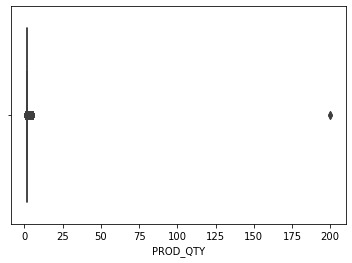

In [55]:
# potential outlier. lets examine for further analysis 

sns.boxplot(x=transactions['PROD_QTY'])

<AxesSubplot:xlabel='PROD_QTY', ylabel='Count'>

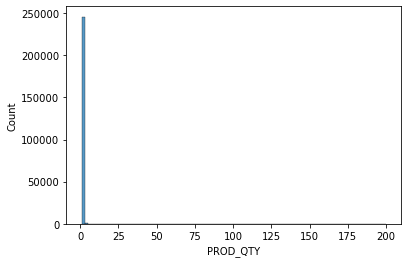

In [56]:
sns.histplot(x=transactions['PROD_QTY'],bins=100)

In [57]:
transactions[transactions['PROD_QTY']>25]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0,380,doritos
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0,380,doritos


In [58]:
transactions[transactions['LYLTY_CARD_NBR']==226000]
# this customer has only made this volume of transaction

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0,380,doritos
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0,380,doritos


In [59]:
# this is an outlier and can affect subsequent analysis it would be eliminated
transactions= transactions[transactions['PROD_QTY']<25]

In [60]:
transactions['PROD_QTY'].describe()

count    246740.000000
mean          1.906456
std           0.342499
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           5.000000
Name: PROD_QTY, dtype: float64

<AxesSubplot:xlabel='PROD_QTY'>

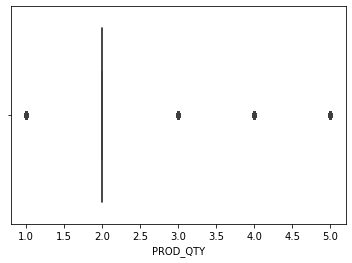

In [61]:
sns.boxplot(x=transactions['PROD_QTY'])

In [62]:
transactions['PROD_QTY'].value_counts()

2    220070
1     25476
5       415
3       408
4       371
Name: PROD_QTY, dtype: int64

In [63]:
# examining total sales column
transactions['TOT_SALES'].describe()

count    246740.000000
mean          7.316113
std           2.474897
min           1.700000
25%           5.800000
50%           7.400000
75%           8.800000
max          29.500000
Name: TOT_SALES, dtype: float64

<AxesSubplot:xlabel='TOT_SALES'>

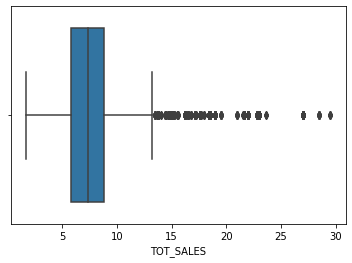

In [64]:
sns.boxplot(x=transactions['TOT_SALES'])

<AxesSubplot:xlabel='TOT_SALES', ylabel='Count'>

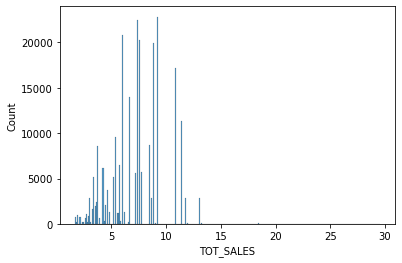

In [65]:
sns.histplot(x=transactions['TOT_SALES'])

In [66]:
# now that datasets are clean lets merge them

merged_data = transactions.merge(customers,how='left', on='LYLTY_CARD_NBR')

In [67]:
merged_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chip compny seasalt175g,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion 175g,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream 175g,2,10.8,175,kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime 175g,1,4.4,175,tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,doritos mexicana 170g,2,8.8,170,doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno 150g,2,7.8,150,doritos,YOUNG SINGLES/COUPLES,Premium


# Customer analysis

In [68]:
# Examing total sales by lifestage and premium customer

In [69]:
# lifestage
lt=merged_data.groupby(['LIFESTAGE'])['TOT_SALES'].sum().sort_values(ascending=False)
lt = np.round((lt/lt.sum())*100,2)
lt

LIFESTAGE
OLDER SINGLES/COUPLES     20.83
RETIREES                  18.97
OLDER FAMILIES            18.20
YOUNG FAMILIES            16.32
YOUNG SINGLES/COUPLES     13.50
MIDAGE SINGLES/COUPLES     9.56
NEW FAMILIES               2.62
Name: TOT_SALES, dtype: float64

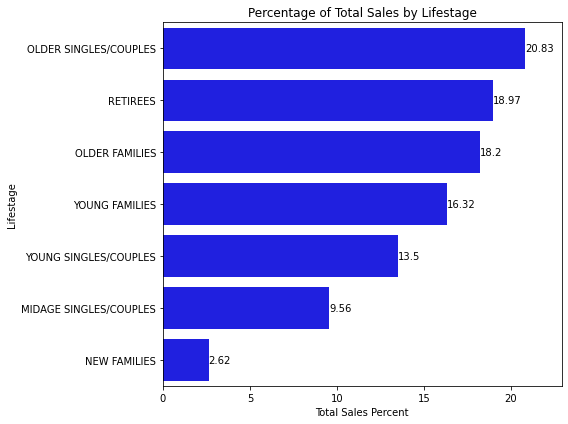

In [70]:
plt.figure(figsize=(8, 6))
sns.barplot(x=lt.values, y=lt.index, color='blue')
for index, value in enumerate(lt.values):
    plt.text(value, index, str(value), fontsize=10, ha='left', va='center')
plt.title('Percentage of Total Sales by Lifestage')
plt.xlabel('Total Sales Percent')
plt.ylabel('Lifestage')
plt.xlim(0, max(lt.values) * 1.1)
plt.tight_layout()
plt.show()

In [71]:
# premium customer
pt=merged_data.groupby(['PREMIUM_CUSTOMER'])['TOT_SALES'].sum().sort_values(ascending=False)
pt = np.round((pt/pt.sum())*100,2)
pt

PREMIUM_CUSTOMER
Mainstream    38.83
Budget        34.98
Premium       26.20
Name: TOT_SALES, dtype: float64

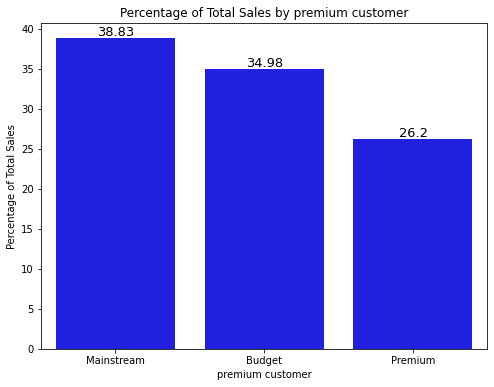

In [72]:
plt.figure(figsize=(8, 6))
sns.barplot(y=pt.values, x=pt.index, color='blue')
for i in range(len(pt)):
    plt.text(i, pt.values[i], str(pt.values[i]), ha='center', va='bottom',fontsize=13)
plt.title('Percentage of Total Sales by premium customer')
plt.xlabel('premium customer')
plt.ylabel('Percentage of Total Sales')
plt.show()

In [73]:
lpt=merged_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
lpt.TOT_SALES = np.round((lpt.TOT_SALES/lpt.TOT_SALES.sum())*100,2)
lpt

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
0,MIDAGE SINGLES/COUPLES,Budget,1.85
1,MIDAGE SINGLES/COUPLES,Mainstream,4.69
2,MIDAGE SINGLES/COUPLES,Premium,3.02
3,NEW FAMILIES,Budget,1.14
4,NEW FAMILIES,Mainstream,0.89
5,NEW FAMILIES,Premium,0.60
6,OLDER FAMILIES,Budget,8.69
7,OLDER FAMILIES,Mainstream,5.34
8,OLDER FAMILIES,Premium,4.17
9,OLDER SINGLES/COUPLES,Budget,7.08


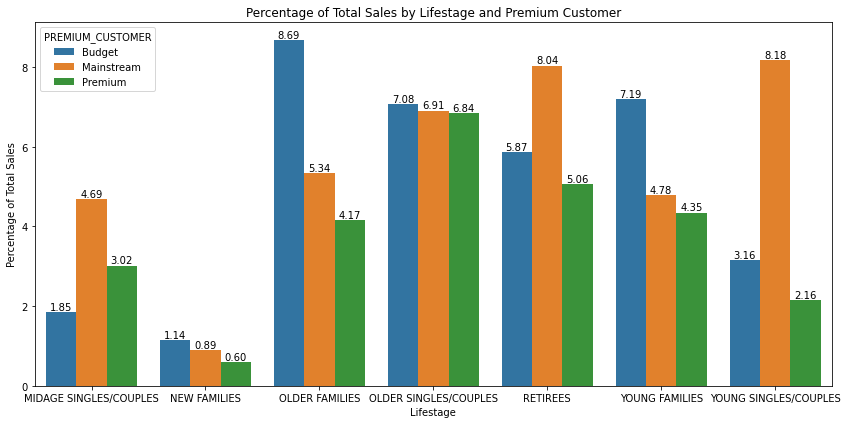

In [74]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=lpt, y='TOT_SALES', x='LIFESTAGE', hue='PREMIUM_CUSTOMER')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Percentage of Total Sales by Lifestage and Premium Customer')
plt.xlabel('Lifestage')
plt.ylabel('Percentage of Total Sales')
plt.tight_layout()

The top 3 customer segments responsible for sales are 

budget older families
mainstream retirees
mainstream yound singles and couples

Let’s see if the higher sales are due to there being more customers who buy chips in these categories

In [75]:
lpn=merged_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
lpn.LYLTY_CARD_NBR = np.round((lpn.LYLTY_CARD_NBR/lpn.LYLTY_CARD_NBR.sum())*100,2)
lpn

,LIFESTAGE,PREMIUM_CUSTOMER,LYLTY_CARD_NBR
0,MIDAGE SINGLES/COUPLES,Budget,2.07
1,MIDAGE SINGLES/COUPLES,Mainstream,4.63
2,MIDAGE SINGLES/COUPLES,Premium,3.32
3,NEW FAMILIES,Budget,1.52
4,NEW FAMILIES,Mainstream,1.16
5,NEW FAMILIES,Premium,0.81
6,OLDER FAMILIES,Budget,6.47
7,OLDER FAMILIES,Mainstream,3.91
8,OLDER FAMILIES,Premium,3.13
9,OLDER SINGLES/COUPLES,Budget,6.80


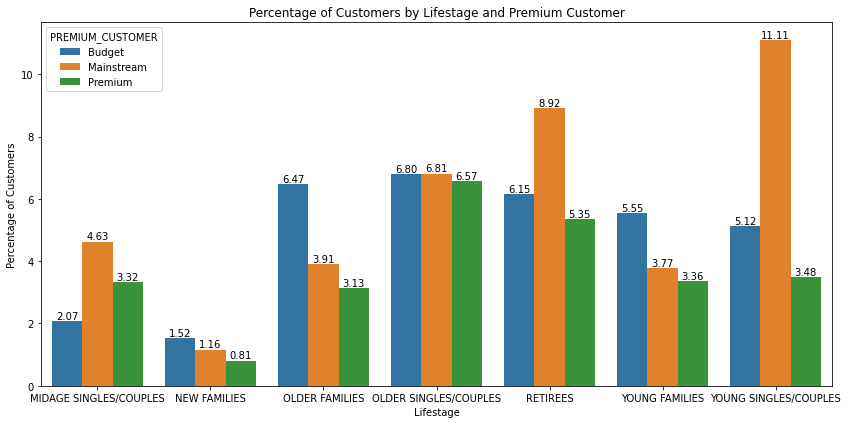

In [76]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=lpn, y='LYLTY_CARD_NBR', x='LIFESTAGE', hue='PREMIUM_CUSTOMER')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Percentage of Customers by Lifestage and Premium Customer')
plt.xlabel('Lifestage')
plt.ylabel('Percentage of Customers')
plt.tight_layout()

It is clear that number of customers is the driver for sales in 

- mainstream retirees
- mainstream yound singles and couples

However this isnt the case in budget older families.

in the case of budget older families, higher chip purchases might be due to another driver like more purchases per customer

lets investigate


In [77]:
lpu=merged_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg({'PROD_QTY': ['sum'], 'LYLTY_CARD_NBR':['nunique']})
lpu['unit_per_customer']=lpu[('PROD_QTY', 'sum')]/lpu[('LYLTY_CARD_NBR', 'nunique')]
lpu=lpu.reset_index()
lpu

,LIFESTAGE,PREMIUM_CUSTOMER,PROD_QTY,LYLTY_CARD_NBR,unit_per_customer
,,,sum,nunique,
0,MIDAGE SINGLES/COUPLES,Budget,8883,1474,6.026459
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,3298,6.432080
2,MIDAGE SINGLES/COUPLES,Premium,14400,2369,6.078514
3,NEW FAMILIES,Budget,5241,1087,4.821527
4,NEW FAMILIES,Mainstream,4060,830,4.891566
5,NEW FAMILIES,Premium,2769,575,4.815652
6,OLDER FAMILIES,Budget,41853,4611,9.076773
7,OLDER FAMILIES,Mainstream,25804,2788,9.255380
8,OLDER FAMILIES,Premium,20239,2231,9.071717


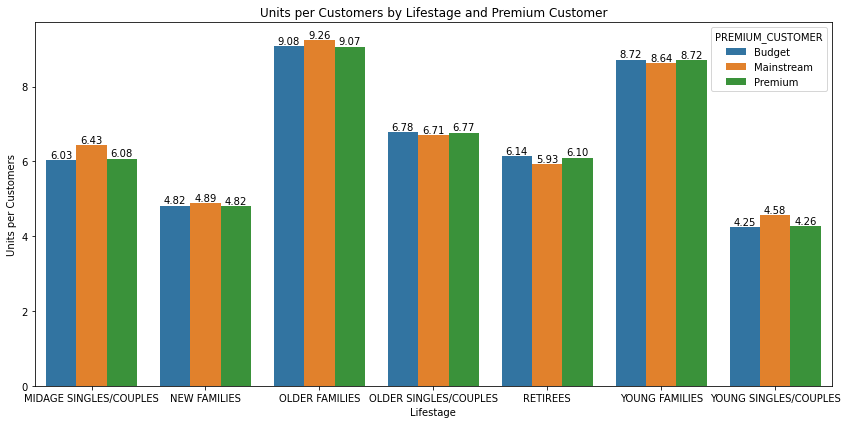

In [78]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=lpu, y='unit_per_customer', x='LIFESTAGE', hue='PREMIUM_CUSTOMER')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Units per Customers by Lifestage and Premium Customer')
plt.xlabel('Lifestage')
plt.ylabel('Units per Customers')
plt.tight_layout()

In general older and younger families buy the most chips per customer

this might explain the sales contributions of budget older families

lets analyze further and examine 

Let’s also investigate the average price per unit chips bought for each customer segment as this is also a
driver of total sales.

In [79]:
lpa=merged_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg({'TOT_SALES':['sum'],'PROD_QTY': ['sum'], })
lpa['average_price_per_unit_purchased']=lpa[('TOT_SALES', 'sum')]/lpa[('PROD_QTY', 'sum')]
lpa=lpa.reset_index()
lpa

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES,PROD_QTY,average_price_per_unit_purchased
,,,sum,sum,
0,MIDAGE SINGLES/COUPLES,Budget,33345.70,8883,3.753878
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25,21213,3.994449
2,MIDAGE SINGLES/COUPLES,Premium,54443.85,14400,3.780823
3,NEW FAMILIES,Budget,20607.45,5241,3.931969
4,NEW FAMILIES,Mainstream,15979.70,4060,3.935887
5,NEW FAMILIES,Premium,10760.80,2769,3.886168
6,OLDER FAMILIES,Budget,156863.75,41853,3.747969
7,OLDER FAMILIES,Mainstream,96413.55,25804,3.736380
8,OLDER FAMILIES,Premium,75242.60,20239,3.717703


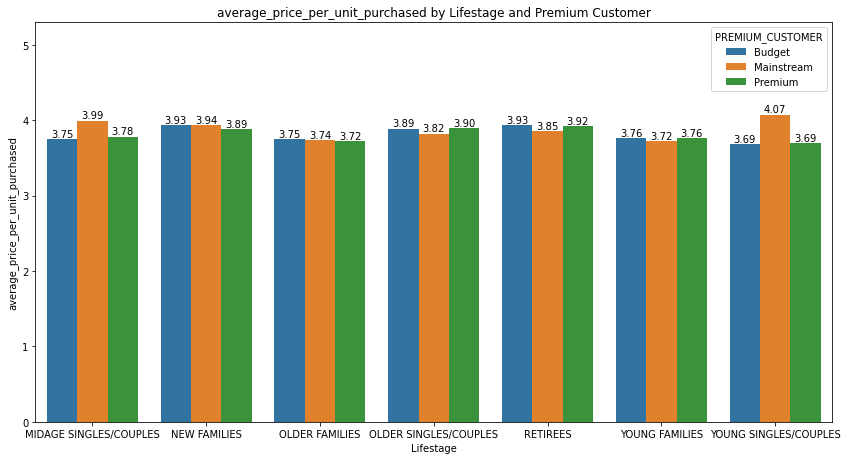

In [80]:
plt.figure(figsize=(12, 6.5))
ax = sns.barplot(data=lpa, y='average_price_per_unit_purchased', x='LIFESTAGE', hue='PREMIUM_CUSTOMER')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('average_price_per_unit_purchased by Lifestage and Premium Customer')
plt.xlabel('Lifestage')
plt.ylabel('average_price_per_unit_purchased')
plt.ylim(0, max(lpa.average_price_per_unit_purchased) * 1.3)
plt.tight_layout()

midage singles/couples and young singles/couples have the most difference in average price per unit purchased between premium categories.


This might be as a result of the premium customers in these categories choosing to opt for healthier snacks.

The budget customers in these categories might be aiming to save on purchases.

However since the difference between these categories is not much we would use a statistical test to verify the significance of this difference

In [81]:
# test significance of difference in young singles/coupless
young= merged_data[(merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]
young['unit_price']=young['TOT_SALES']/young['PROD_QTY']
young

C:\Users\adenu\AppData\Local\Temp\ipykernel_7800\120999336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  young['unit_price']=young['TOT_SALES']/young['PROD_QTY']


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER,unit_price
0,2018-10-17,1,1000,1,5,natural chip compny seasalt175g,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium,3.0
212772,2018-11-09,77,2330311,236755,90,tostitos smoked chipotle 175g,1,4.4,175,tostitos,YOUNG SINGLES/COUPLES,Budget,4.4
212773,2019-05-16,1,1076,87,107,smiths crinkle cut french oniondip 150g,1,2.6,150,smiths,YOUNG SINGLES/COUPLES,Budget,2.6
212774,2019-05-17,1,1165,192,12,natural chip co tmato hrb&spce 175g,1,3.0,175,natural,YOUNG SINGLES/COUPLES,Budget,3.0
212775,2018-08-16,1,1282,319,67,rrd chilli& coconut 150g,1,2.7,150,red,YOUNG SINGLES/COUPLES,Budget,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream 175g,2,10.8,175,kettle,YOUNG SINGLES/COUPLES,Premium,5.4
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime 175g,1,4.4,175,tostitos,YOUNG SINGLES/COUPLES,Premium,4.4
246737,2018-11-06,272,272379,270187,51,doritos mexicana 170g,2,8.8,170,doritos,YOUNG SINGLES/COUPLES,Premium,4.4
246738,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno 150g,2,7.8,150,doritos,YOUNG SINGLES/COUPLES,Premium,3.9


In [82]:
t_statistic, p_value = ttest_ind(young['unit_price'][young['PREMIUM_CUSTOMER'] == 'Mainstream'], young['unit_price'][young['PREMIUM_CUSTOMER'] != 'Mainstream'], alternative='greater')

# Print results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 35.339232724079785
P-Value: 5.4924746573032226e-269


This results show that the difference is significant as the p value is less than 0.05

In [83]:
# test significance of difference in midage singles/coupless
midage= merged_data[(merged_data['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')]
midage['unit_price']=midage['TOT_SALES']/midage['PROD_QTY']
midage

C:\Users\adenu\AppData\Local\Temp\ipykernel_7800\782554333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midage['unit_price']=midage['TOT_SALES']/midage['PROD_QTY']


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER,unit_price
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget,1.45
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion 175g,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget,3.00
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget,4.60
5,2019-05-16,4,4149,3333,16,smiths crinkle chips salt & vinegar 330g,1,5.7,330,smiths,MIDAGE SINGLES/COUPLES,Budget,5.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23394,2019-05-13,272,272333,270111,47,doritos corn chips original 170g,2,8.8,170,doritos,MIDAGE SINGLES/COUPLES,Premium,4.40
23395,2018-09-26,272,272392,270206,70,tyrrells crisps lightly salted 165g,2,8.4,165,tyrrells,MIDAGE SINGLES/COUPLES,Premium,4.20
23396,2018-09-29,272,272392,270207,75,cobs popd sea salt chips 110g,2,7.6,110,cobs,MIDAGE SINGLES/COUPLES,Premium,3.80
23397,2018-10-31,272,272392,270208,81,pringles original crisps 134g,2,7.4,134,pringles,MIDAGE SINGLES/COUPLES,Premium,3.70


In [84]:
t_statistic, p_value = ttest_ind(midage['unit_price'][midage['PREMIUM_CUSTOMER'] == 'Mainstream'], midage['unit_price'][midage['PREMIUM_CUSTOMER'] != 'Mainstream'], alternative='greater')

# Print results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 16.814983102714304
P-Value: 2.2249649794071478e-63


This results show that the difference is significant as the p value is less than 0.05

## Product category analysis based on preferred customers



Divide data into 
- preferred customers (top three customer segments by total sales)
        budget older families
        mainstream retirees
        mainstream yound singles and couples


- other customers 

In [85]:
merged_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chip compny seasalt175g,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion 175g,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream 175g,2,10.8,175,kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime 175g,1,4.4,175,tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,doritos mexicana 170g,2,8.8,170,doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno 150g,2,7.8,150,doritos,YOUNG SINGLES/COUPLES,Premium


In [86]:
preferred= merged_data[((merged_data['LIFESTAGE'] == 'OLDER FAMILIES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Budget' )) | ((merged_data['LIFESTAGE'] == 'RETIREES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' )) | ((merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' ))]
preferred

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
29896,2018-07-21,77,2330461,236777,87,infuzions bbq rib prawn crackers 110g,1,3.8,110,infuzions,OLDER FAMILIES,Budget
29897,2019-05-20,1,1367,424,7,smiths crinkle original 330g,1,5.7,330,smiths,OLDER FAMILIES,Budget
29898,2018-08-17,3,3088,1462,89,kettle sweet chilli and sour cream 175g,2,10.8,175,kettle,OLDER FAMILIES,Budget
29899,2018-08-14,3,3147,1698,16,smiths crinkle chips salt & vinegar 330g,1,5.7,330,smiths,OLDER FAMILIES,Budget
29900,2019-05-16,3,3206,1979,71,twisties cheese burger 250g,1,4.3,250,twisties,OLDER FAMILIES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
240884,2018-12-01,272,272377,270186,75,cobs popd sea salt chips 110g,2,7.6,110,cobs,YOUNG SINGLES/COUPLES,Mainstream
240885,2018-07-27,272,272389,270200,114,kettle sensations siracha lime 150g,2,9.2,150,kettle,YOUNG SINGLES/COUPLES,Mainstream
240886,2018-11-10,272,272389,270201,26,pringles sweet&spcy bbq 134g,2,7.4,134,pringles,YOUNG SINGLES/COUPLES,Mainstream
240887,2019-04-01,272,272389,270202,62,pringles mystery flavour 134g,2,7.4,134,pringles,YOUNG SINGLES/COUPLES,Mainstream


In [87]:
other= merged_data[~(((merged_data['LIFESTAGE'] == 'OLDER FAMILIES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Budget' )) | ((merged_data['LIFESTAGE'] == 'RETIREES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' )) | ((merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' )))]
other

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chip compny seasalt175g,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion 175g,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream 175g,2,10.8,175,kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime 175g,1,4.4,175,tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,doritos mexicana 170g,2,8.8,170,doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno 150g,2,7.8,150,doritos,YOUNG SINGLES/COUPLES,Premium


In [88]:
preferred_brand=preferred.groupby(['BRAND_NAME'])['PROD_QTY'].sum()
preferred_brand=(preferred_brand/preferred_brand.sum())*100
preferred_brand=preferred_brand.reset_index()
preferred_brand.rename(columns={'PROD_QTY':'Purchase_Proportion_Preferred'}, inplace=True)

In [89]:
preferred_brand

,BRAND_NAME,Purchase_Proportion_Preferred
0,burger,0.548572
1,ccs,1.688048
2,cheetos,1.105784
3,cheezels,1.911796
4,cobs,3.968727
5,doritos,10.689819
6,french,0.514881
7,grnwves,3.230098
8,infuzions,5.953954
9,kettle,17.357350


In [90]:
other = other.groupby(['BRAND_NAME'])['PROD_QTY'].sum()
other = (other / other.sum()) * 100
other=other.reset_index()
other.rename(columns={'PROD_QTY':'Purchase_Proportion_Other'}, inplace=True)


In [91]:
other

,BRAND_NAME,Purchase_Proportion_Other
0,burger,0.658407
1,ccs,1.876530
2,cheetos,1.198385
3,cheezels,1.842411
4,cobs,3.941135
5,doritos,10.138900
6,french,0.577199
7,grnwves,3.098036
8,infuzions,5.703466
9,kettle,16.624841


In [92]:
preffered_brand_affinity = pd.merge(preferred_brand, other, on='BRAND_NAME')
preffered_brand_affinity

,BRAND_NAME,Purchase_Proportion_Preferred,Purchase_Proportion_Other
0,burger,0.548572,0.658407
1,ccs,1.688048,1.876530
2,cheetos,1.105784,1.198385
3,cheezels,1.911796,1.842411
4,cobs,3.968727,3.941135
5,doritos,10.689819,10.138900
6,french,0.514881,0.577199
7,grnwves,3.230098,3.098036
8,infuzions,5.953954,5.703466
9,kettle,17.357350,16.624841


In [93]:
preffered_brand_affinity['affinity'] = preffered_brand_affinity.Purchase_Proportion_Preferred/preffered_brand_affinity.Purchase_Proportion_Other
#preffered_brand_affinity = preferred_brand/other
preffered_brand_affinity

,BRAND_NAME,Purchase_Proportion_Preferred,Purchase_Proportion_Other,affinity
0,burger,0.548572,0.658407,0.833182
1,ccs,1.688048,1.876530,0.899558
2,cheetos,1.105784,1.198385,0.922728
3,cheezels,1.911796,1.842411,1.037660
4,cobs,3.968727,3.941135,1.007001
5,doritos,10.689819,10.138900,1.054337
6,french,0.514881,0.577199,0.892034
7,grnwves,3.230098,3.098036,1.042628
8,infuzions,5.953954,5.703466,1.043919
9,kettle,17.357350,16.624841,1.044061


In [94]:
preffered_brand_affinity = round(preffered_brand_affinity,3)
preffered_brand_affinity

,BRAND_NAME,Purchase_Proportion_Preferred,Purchase_Proportion_Other,affinity
0,burger,0.549,0.658,0.833
1,ccs,1.688,1.877,0.900
2,cheetos,1.106,1.198,0.923
3,cheezels,1.912,1.842,1.038
4,cobs,3.969,3.941,1.007
5,doritos,10.690,10.139,1.054
6,french,0.515,0.577,0.892
7,grnwves,3.230,3.098,1.043
8,infuzions,5.954,5.703,1.044
9,kettle,17.357,16.625,1.044


In [95]:
preffered_brand_affinity.describe()

,Purchase_Proportion_Preferred,Purchase_Proportion_Other,affinity
count,20.000000,20.000000,20.000000
mean,5.000000,4.999850,0.973850
std,4.428807,4.290985,0.077405
min,0.515000,0.577000,0.833000
25%,1.856000,1.868250,0.907500
50%,3.894500,3.813000,0.997500
75%,6.012250,5.950000,1.042250
max,17.357000,16.625000,1.099000


The affinity column does not yield that much new information as the range of values are very small.

This indicates that the preferred customers to not prefer a particular brand especially compared to how other brands are purchased by other customers.

However this analysis reveals that certain brands are prefferred by our preferred customers.

Lets dive in

In [107]:
preffered_brand_affinity = preffered_brand_affinity[['BRAND_NAME','Purchase_Proportion_Preferred']].sort_values('Purchase_Proportion_Preferred',ascending=False)
preffered_brand_affinity

,BRAND_NAME,Purchase_Proportion_Preferred
9,kettle,17.357
13,smiths,11.775
5,doritos,10.690
11,pringles,10.527
12,red,6.187
8,infuzions,5.954
15,thins,5.826
19,woolworths,4.224
17,twisties,4.131
4,cobs,3.969


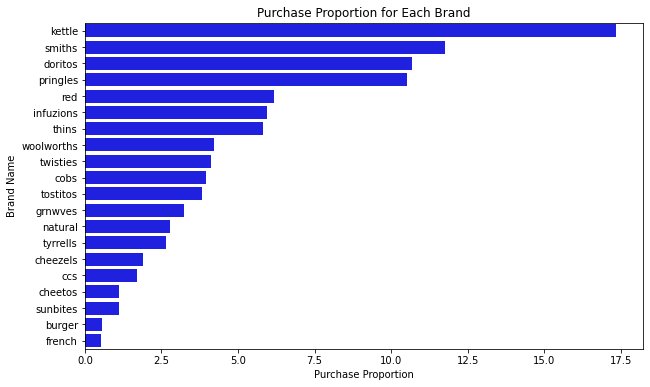

In [109]:
# visualize this data

plt.figure(figsize=(10, 6))
sns.barplot(x='Purchase_Proportion_Preferred', y='BRAND_NAME', data=preffered_brand_affinity, color='blue')

plt.xlabel('Purchase Proportion')
plt.ylabel('Brand Name')
plt.title('Purchase Proportion for Each Brand')

plt.show()

The most preferred brands are 
- kettle
- smith
- doritos
- pringles

Lets investigate parkage sizes

In [97]:
preferred= merged_data[((merged_data['LIFESTAGE'] == 'OLDER FAMILIES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Budget' )) | ((merged_data['LIFESTAGE'] == 'RETIREES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' )) | ((merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' ))]
other= merged_data[~(((merged_data['LIFESTAGE'] == 'OLDER FAMILIES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Budget' )) | ((merged_data['LIFESTAGE'] == 'RETIREES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' )) | ((merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES' ) & (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream' )))]


In [98]:
preferred_size=preferred.groupby(['SIZE'])['PROD_QTY'].sum()
preferred_size=(preferred_size/preferred_size.sum())*100
preferred_size=preferred_size.reset_index()
preferred_size.rename(columns={'PROD_QTY':'Purchase_Proportion_Preferred'}, inplace=True)
preferred_size

,SIZE,Purchase_Proportion_Preferred
0,110,9.374109
1,125,0.546845
2,134,10.527407
3,135,1.348538
4,150,16.309447
5,160,1.066045
6,165,5.933221
7,170,8.197486
8,175,26.371215
9,180,0.587448


In [99]:
other = other.groupby(['SIZE'])['PROD_QTY'].sum()
other = (other / other.sum()) * 100
other=other.reset_index()
other.rename(columns={'PROD_QTY':'Purchase_Proportion_Other'}, inplace=True)
other

,SIZE,Purchase_Proportion_Other
0,110,9.018621
1,125,0.591297
2,134,10.103935
3,135,1.311456
4,150,16.293241
5,160,1.232222
6,165,6.255005
7,170,8.064143
8,175,27.052763
9,180,0.587632


In [100]:
preffered_size_affinity = pd.merge(preferred_size, other, on='SIZE')
preffered_size_affinity

,SIZE,Purchase_Proportion_Preferred,Purchase_Proportion_Other
0,110,9.374109,9.018621
1,125,0.546845,0.591297
2,134,10.527407,10.103935
3,135,1.348538,1.311456
4,150,16.309447,16.293241
5,160,1.066045,1.232222
6,165,5.933221,6.255005
7,170,8.197486,8.064143
8,175,26.371215,27.052763
9,180,0.587448,0.587632


In [101]:
preffered_size_affinity['affinity'] = preffered_size_affinity.Purchase_Proportion_Preferred/preffered_size_affinity.Purchase_Proportion_Other

preffered_size_affinity=round(preffered_size_affinity,3)

In [102]:
preffered_size_affinity

,SIZE,Purchase_Proportion_Preferred,Purchase_Proportion_Other,affinity
0,110,9.374,9.019,1.039
1,125,0.547,0.591,0.925
2,134,10.527,10.104,1.042
3,135,1.349,1.311,1.028
4,150,16.309,16.293,1.001
5,160,1.066,1.232,0.865
6,165,5.933,6.255,0.949
7,170,8.197,8.064,1.017
8,175,26.371,27.053,0.975
9,180,0.587,0.588,1.000


In [103]:
preffered_size_affinity.describe()

,Purchase_Proportion_Preferred,Purchase_Proportion_Other,affinity
count,20.000000,20.000000,20.00000
mean,5.000000,5.000000,0.97690
std,6.587664,6.657245,0.08795
min,0.547000,0.588000,0.83300
25%,1.093000,1.237250,0.88950
50%,2.103000,2.185000,1.00050
75%,6.499000,6.707250,1.03975
max,26.371000,27.053000,1.10800


just as discovered with the brand name analysis

The affinity column does not yield that much new information as the range of values are very small.

This indicates that the preferred customers to not prefer a particular brand especially compared to how other brands are purchased by other customers.

However this analysis reveals that certain brands are prefferred by our preferred customers.

Lets dive in

In [110]:
preffered_size_affinity=preffered_size_affinity[['SIZE','Purchase_Proportion_Preferred']].sort_values('Purchase_Proportion_Preferred',ascending=False)
preffered_size_affinity

,SIZE,Purchase_Proportion_Preferred
8,175,26.371
4,150,16.309
2,134,10.527
0,110,9.374
7,170,8.197
6,165,5.933
16,330,5.420
15,270,2.739
17,380,2.678
12,210,2.643


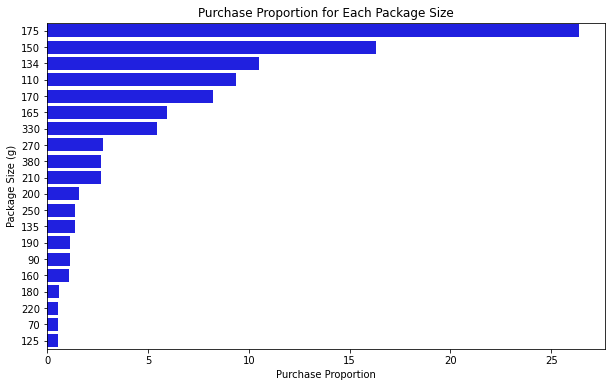

In [114]:
# visualize this data

plt.figure(figsize=(10, 6))
sns.barplot(x='Purchase_Proportion_Preferred', y='SIZE', data=preffered_size_affinity, color='blue')

plt.xlabel('Purchase Proportion')
plt.ylabel('Package Size (g)')
plt.title('Purchase Proportion for Each Package Size')

plt.show()

The most preferred sizes are 
- 175g
- 150g
- 134g
- 110g
- 170g